Notebook peu commenté, définition de l'expérience "small MNIST".

In [8]:
import numpy as np

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

batch_size = 100
nb_classes = 10
nb_epoch = 12

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

model = Sequential()

model.add(Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                        border_mode='valid',
                        input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [9]:
a = model.get_weights()

In [10]:
for el in a:
    print(el.shape)

(32, 1, 3, 3)
(32,)
(5408, 10)
(10,)


In [5]:
n_samples = X_train.shape[0] #60000

In [7]:
X_test.shape

(10000, 1, 28, 28)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator().flow(X_train, Y_train, 
                                batch_size=batch_size, 
                                shuffle=True) #used to shuffle data between epochs

In [15]:
import time

In [17]:
from IPython.display import clear_output

for i in range(10):
    print(i)
    time.sleep(1)
    clear_output()

In [30]:
init_time = time.time()
times = []
losses = []
alpha = 0.01
nb_epoch = 2

for e in range(nb_epoch):
    n_batches = n_samples//batch_size
    
    center = None
    for i in range(n_batches):
        X_b, y_b = next(gen)
        
        # wait for controller to send center
        # testing :
        if center is None:
            center = model.get_weights()
        
        if i%100 == 0:
            clear_output()
            print("Epoch : {}/{}\nBatch : {}/{}".format(
                        e, nb_epoch, i, n_batches
            ))
        loss, acc = model.train_on_batch(X_b, y_b)
        losses.append(loss)
        times.append(time.time()-init_time)
        
        # update weight with center variable
        weights = model.get_weights()
        
        for j in range(len(weights)):
            weights[j] = weights[j] - alpha * (weights[j] - center[j])
            
        model.set_weights(weights)

loss, acc = model.evaluate(X_test,Y_test,batch_size=batch_size,verbose=0)
print("\n\tAccuracy : {:.2f}%".format(acc*100))

Epoch : 1/2
Batch : 500/600

	Accuracy : 95.18%


In [34]:
model.optimizer.lr.value

Exception: sharedvar.value does not exist anymore. Use sharedvar.get_value() or sharedvar.set_value() instead.

In [14]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.epoch = 0
        
        import time
        self.init_time = time.time()
        self.times = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        
        import time
        self.times.append(time.time())
        
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        print(self.epoch)

history = LossHistory()

model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0, validation_data=(X_test, Y_test), callbacks=[history])
score = model.evaluate(X_test, Y_test, verbose=0)

1
2
3
4
5
6
7
8
9
10
11
12


In [6]:
from matplotlib import pyplot as plt

/home/naas/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [7]:
%matplotlib inline

In [15]:
dt = [t - history.init_time for t in history.times]

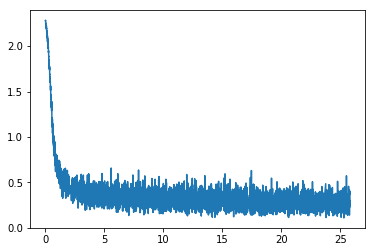

In [16]:
plt.plot(dt, history.losses)

In [45]:
import pickle
gpu0_hist = pickle.load(open('pyzmq_tests/sml_gpu_0.pkl', 'rb'))
gpu1_hist = pickle.load(open('pyzmq_tests/sml_gpu_1.pkl', 'rb'))
sgpu_hist = pickle.load(open('small_mnist_gpu.pkl', 'rb'))

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

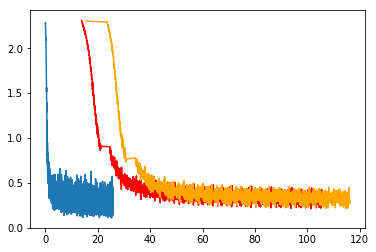

In [49]:
plt.plot(gpu1_hist['dt'], gpu1_hist['loss'], 'r-')
plt.plot(gpu0_hist['dt'], gpu0_hist['loss'], 'orange')
plt.plot(sgpu_hist['dt'], sgpu_hist['loss'])

In [21]:
dt[-1]

25.80326271057129

In [22]:
cpu_hist['dt'][-1]

208.72261118888855

In [24]:
pickle.dump({'dt':dt, 'loss':history.losses}, open('small_mnist_gpu.pkl', 'wb'))